In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import talib as ta

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go
import itertools

In [3]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from numpy.linalg import eig
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier

from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [4]:
import yfinance as yf

In [6]:
ticker = yf.Ticker('BTC-USD')
# BTC_df = ticker.history(start="2017-01-02", end="2022-02-28")
BTC_df = ticker.history(period ='max')

# EDA on the data
We should drop Dividends and stock splits 

In [7]:
BTC_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0
...,...,...,...,...,...,...,...
2022-03-14,37846.316406,39742.500000,37680.734375,39666.753906,24322159070,0,0
2022-03-15,39664.250000,39794.628906,38310.210938,39338.785156,23934000868,0,0
2022-03-16,39335.570312,41465.453125,39022.347656,41143.929688,39616916192,0,0


The data is an index, i need to reset it and make it as a column

In [8]:
BTC_df.reset_index(inplace=True)

In [9]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

Text(0.5, 1.0, 'Bitcoin Price')

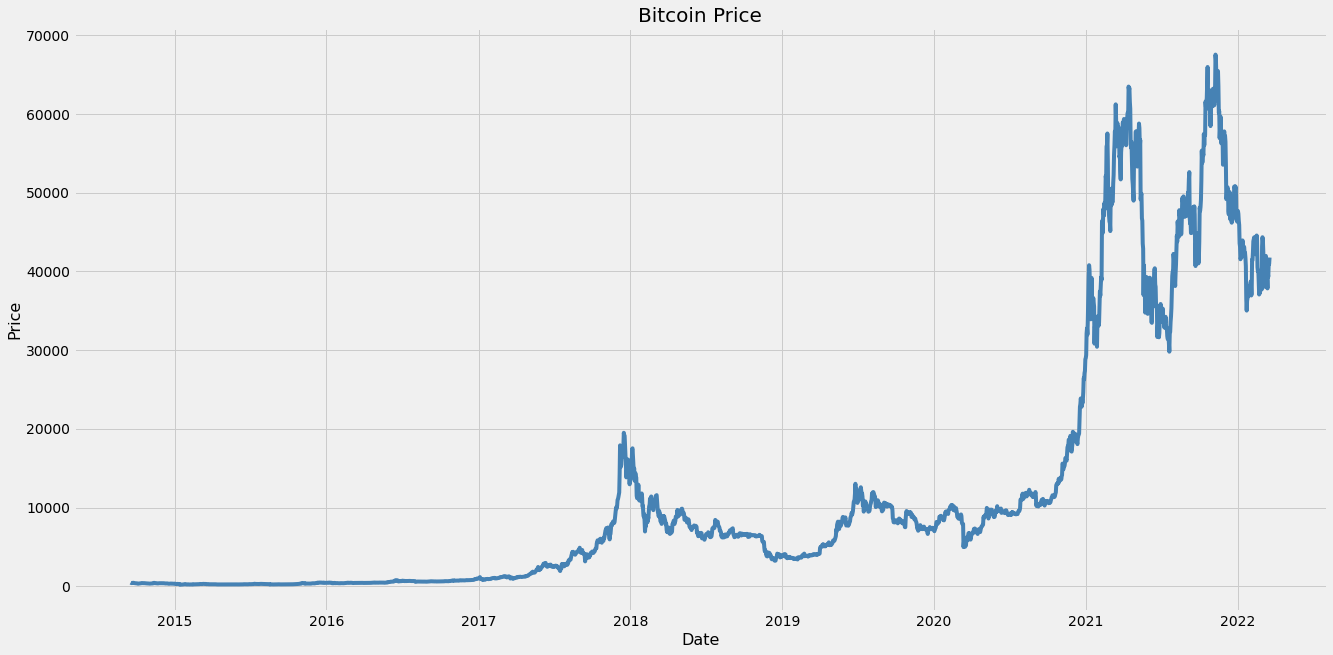

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(BTC_df['Date'],BTC_df['Close'], color='steelblue')
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Price', fontsize = 16)
ax.set_title('Bitcoin Price', fontsize = 20)

# Volumn chart 

Text(0.5, 1.0, 'Bitcoin Volume')

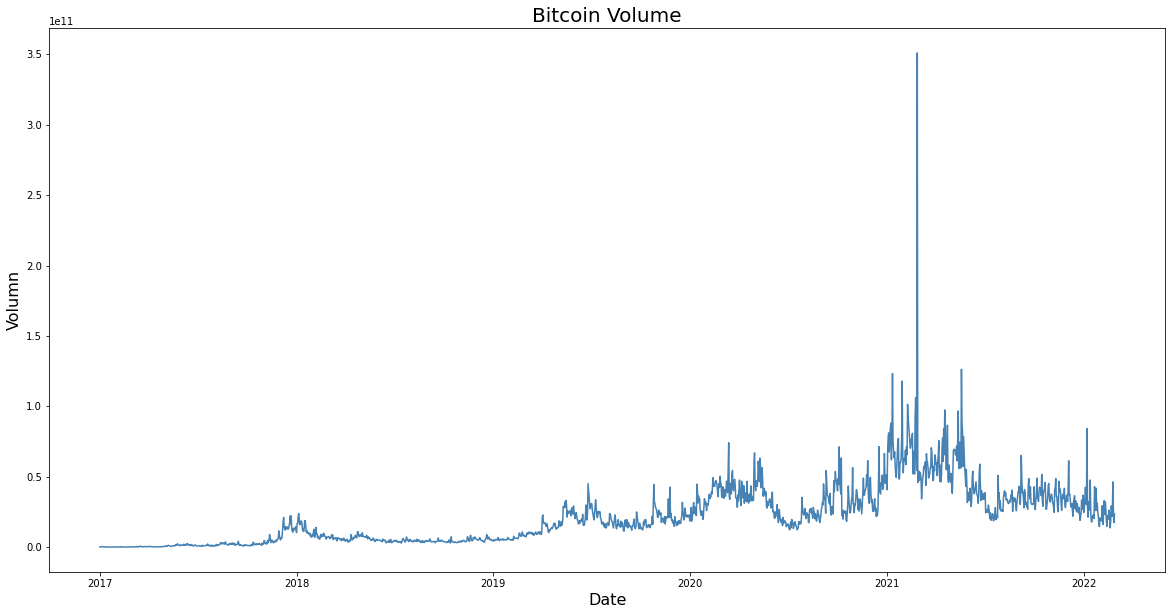

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(BTC_df['Date'],BTC_df['Volume'], color='steelblue')
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Volumn', fontsize = 16)
ax.set_title('Bitcoin Volume', fontsize = 20)


In [9]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1884 non-null   datetime64[ns]
 1   Open          1884 non-null   float64       
 2   High          1884 non-null   float64       
 3   Low           1884 non-null   float64       
 4   Close         1884 non-null   float64       
 5   Volume        1884 non-null   int64         
 6   Dividends     1884 non-null   int64         
 7   Stock Splits  1884 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 117.9 KB


In [10]:
BTC_df.drop(['Dividends', 'Stock Splits'], axis = 1, inplace= True)

In [11]:
BTC_df

,Date,Open,High,Low,Close,Volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...,...
1879,2022-02-23,38285.281250,39122.394531,37201.816406,37296.570312,21849073843
1880,2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,46383802093
1881,2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,26545599159
1882,2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,17467554129


In [12]:
# Moving Average
BTC_df['MA_50'] = ta.MA(BTC_df['Close'].values, timeperiod=50)
BTC_df['MA_200'] = ta.MA(BTC_df['Close'].values, timeperiod=200)

# Simple Moving Average
BTC_df['SMA_50'] = ta.SMA(BTC_df['Close'].values, timeperiod=50)
BTC_df['SMA_200'] = ta.SMA(BTC_df['Close'].values, timeperiod=200)

# Exponential moving average
BTC_df['EMA_12'] = ta.EMA(BTC_df['Close'].values, timeperiod=12)
BTC_df['EMA_26'] = ta.EMA(BTC_df['Close'].values, timeperiod=26)

# Moving average convergence divergence (MACD)
BTC_df['macd'], BTC_df['macdsignal'], BTC_df['macdhist'] = ta.MACD(BTC_df['Close'].values, fastperiod=12, slowperiod=26, signalperiod= 9)

# Relative Strength index (RSI)
BTC_df['rsi_5'] = ta.RSI(BTC_df['Close'].values, timeperiod=5)
BTC_df['rsi_14'] = ta.RSI(BTC_df['Close'].values, timeperiod=14)

#Bollinger Band (BB)
BTC_df['BB_Upper'], BTC_df['BB_middle'], BTC_df['BB_lower'] = ta.BBANDS(BTC_df['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)


In [13]:
BTC_df

,Date,Open,High,Low,Close,Volume,MA_50,MA_200,SMA_50,SMA_200,EMA_12,EMA_26,macd,macdsignal,macdhist,rsi_5,rsi_14,BB_Upper,BB_middle,BB_lower
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,2022-02-23,38285.281250,39122.394531,37201.816406,37296.570312,21849073843,40619.632969,49346.491367,40619.632969,49346.491367,39756.843754,40529.235780,-772.392026,-178.537677,-593.854350,27.529069,37.529047,46152.580286,41548.570898,36944.561511
1880,2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,46383802093,40514.905078,49319.163828,40514.905078,49319.163828,39537.730773,40366.522713,-828.791941,-308.588529,-520.203411,41.080920,42.098947,46203.114098,41390.157617,36577.201136
1881,2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,26545599159,40435.970859,49283.407910,40435.970859,49283.407910,39487.959692,40281.166864,-793.207172,-405.512258,-387.694914,50.855907,45.736592,46184.050294,41278.810352,36373.570409
1882,2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,17467554129,40386.915781,49251.008496,40386.915781,49251.008496,39429.065653,40194.054388,-764.988735,-477.407553,-287.581182,49.583752,45.356934,46077.309351,41113.446094,36149.582836


In order to know whether the day have gains/losses, i will check whether the close price is higher or lower than the open prices. 
Higher than closing price is 1
Lower than closing price is 0 

In [14]:
outcome = BTC_df['Close'] > BTC_df['Open']
BTC_df['Profit_or_loss'] = outcome
BTC_df['Profit_or_loss'] = BTC_df['Profit_or_loss'].replace(True, 1)
BTC_df['Profit_or_loss'] = BTC_df['Profit_or_loss'].replace(False, 0)
BTC_df

,Date,Open,High,Low,Close,Volume,MA_50,MA_200,SMA_50,SMA_200,...,EMA_26,macd,macdsignal,macdhist,rsi_5,rsi_14,BB_Upper,BB_middle,BB_lower,Profit_or_loss
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,2022-02-23,38285.281250,39122.394531,37201.816406,37296.570312,21849073843,40619.632969,49346.491367,40619.632969,49346.491367,...,40529.235780,-772.392026,-178.537677,-593.854350,27.529069,37.529047,46152.580286,41548.570898,36944.561511,0
1880,2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,46383802093,40514.905078,49319.163828,40514.905078,49319.163828,...,40366.522713,-828.791941,-308.588529,-520.203411,41.080920,42.098947,46203.114098,41390.157617,36577.201136,1
1881,2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,26545599159,40435.970859,49283.407910,40435.970859,49283.407910,...,40281.166864,-793.207172,-405.512258,-387.694914,50.855907,45.736592,46184.050294,41278.810352,36373.570409,1
1882,2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,17467554129,40386.915781,49251.008496,40386.915781,49251.008496,...,40194.054388,-764.988735,-477.407553,-287.581182,49.583752,45.356934,46077.309351,41113.446094,36149.582836,0


In [15]:
BTC_df.isnull().sum()

Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
MA_50              49
MA_200            199
SMA_50             49
SMA_200           199
EMA_12             11
EMA_26             25
macd               33
macdsignal         33
macdhist           33
rsi_5               5
rsi_14             14
BB_Upper           19
BB_middle          19
BB_lower           19
Profit_or_loss      0
dtype: int64

In [16]:
BTC_df.fillna(0, inplace= True)

In [17]:
BTC_df.duplicated().sum()

0

In [18]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1884 non-null   datetime64[ns]
 1   Open            1884 non-null   float64       
 2   High            1884 non-null   float64       
 3   Low             1884 non-null   float64       
 4   Close           1884 non-null   float64       
 5   Volume          1884 non-null   int64         
 6   MA_50           1884 non-null   float64       
 7   MA_200          1884 non-null   float64       
 8   SMA_50          1884 non-null   float64       
 9   SMA_200         1884 non-null   float64       
 10  EMA_12          1884 non-null   float64       
 11  EMA_26          1884 non-null   float64       
 12  macd            1884 non-null   float64       
 13  macdsignal      1884 non-null   float64       
 14  macdhist        1884 non-null   float64       
 15  rsi_

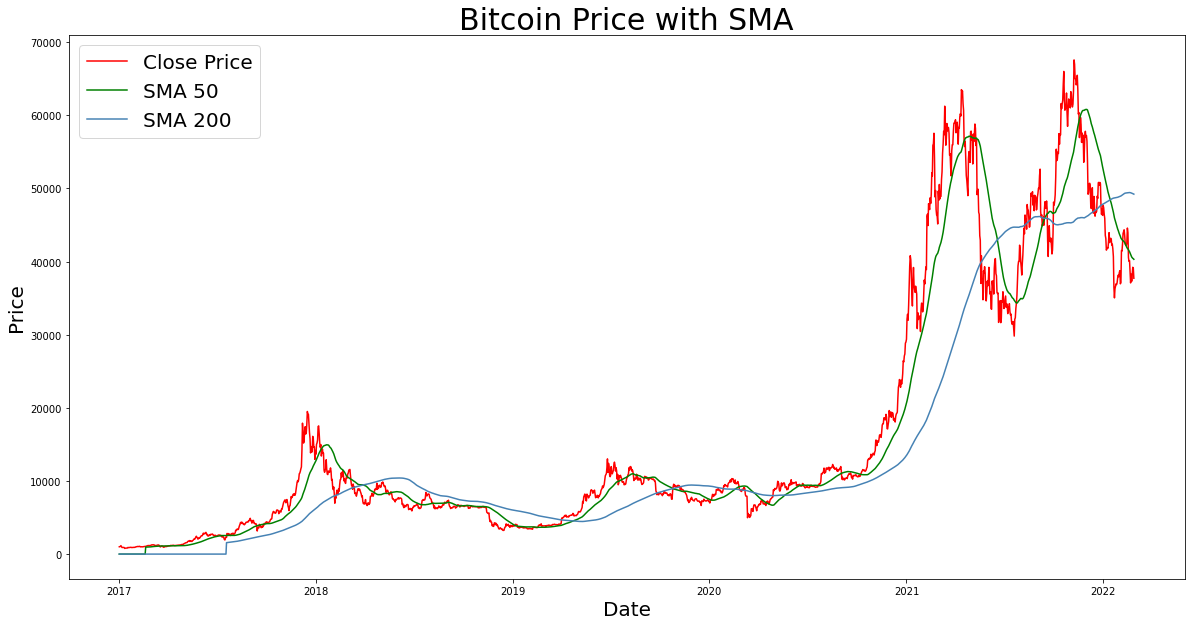

In [19]:
# Moving Average Price 
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(BTC_df['Date'],BTC_df['Close'], color='r', label = 'Close Price')
ax.plot(BTC_df['Date'],BTC_df['MA_50'], color='g', label = 'SMA 50')
ax.plot(BTC_df['Date'],BTC_df['MA_200'], color='steelblue', label = 'SMA 200')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Price', fontsize = 20)
ax.set_title('Bitcoin Price with SMA', fontsize = 30)
ax.legend(loc='upper left',prop={'size': 20})

In [20]:
# moving average graph
fig = go.Figure(go.Candlestick(x=BTC_df['Date'],open=BTC_df['Open'],high=BTC_df['High'],low=BTC_df['Low'],close=BTC_df['Close']))
fig.update_layout(title='Bitcoin Price', yaxis_title='BTC')
fig.update_yaxes(type="log")
fig.add_trace(go.Scatter(x=BTC_df['Date'], y=BTC_df['Close'],mode='lines',name='Close'))
fig.add_trace(go.Scatter(x=BTC_df['Date'], y=BTC_df['MA_50'], mode='lines', name='MA_50',line=dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=BTC_df['Date'], y=BTC_df['MA_200'], mode='lines', name='MA_200', line=dict(color='#555555', width=2)))
fig.show()

In [21]:
# BTC_df['previous_day_closing_price'] = BTC_df['Close'].shift(1)

In [22]:
# BTC_df

# Feature selection on the following column, This is an example for me to try out using prediction for 1 day

# I need to split my training data and testing data so they don't overlap. when i do my prediction against the test data. we lets check whether it matches with the actual data 

In [23]:
BTC_df

,Date,Open,High,Low,Close,Volume,MA_50,MA_200,SMA_50,SMA_200,...,EMA_26,macd,macdsignal,macdhist,rsi_5,rsi_14,BB_Upper,BB_middle,BB_lower,Profit_or_loss
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,2022-02-23,38285.281250,39122.394531,37201.816406,37296.570312,21849073843,40619.632969,49346.491367,40619.632969,49346.491367,...,40529.235780,-772.392026,-178.537677,-593.854350,27.529069,37.529047,46152.580286,41548.570898,36944.561511,0
1880,2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,46383802093,40514.905078,49319.163828,40514.905078,49319.163828,...,40366.522713,-828.791941,-308.588529,-520.203411,41.080920,42.098947,46203.114098,41390.157617,36577.201136,1
1881,2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,26545599159,40435.970859,49283.407910,40435.970859,49283.407910,...,40281.166864,-793.207172,-405.512258,-387.694914,50.855907,45.736592,46184.050294,41278.810352,36373.570409,1
1882,2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,17467554129,40386.915781,49251.008496,40386.915781,49251.008496,...,40194.054388,-764.988735,-477.407553,-287.581182,49.583752,45.356934,46077.309351,41113.446094,36149.582836,0


In [24]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1884 non-null   datetime64[ns]
 1   Open            1884 non-null   float64       
 2   High            1884 non-null   float64       
 3   Low             1884 non-null   float64       
 4   Close           1884 non-null   float64       
 5   Volume          1884 non-null   int64         
 6   MA_50           1884 non-null   float64       
 7   MA_200          1884 non-null   float64       
 8   SMA_50          1884 non-null   float64       
 9   SMA_200         1884 non-null   float64       
 10  EMA_12          1884 non-null   float64       
 11  EMA_26          1884 non-null   float64       
 12  macd            1884 non-null   float64       
 13  macdsignal      1884 non-null   float64       
 14  macdhist        1884 non-null   float64       
 15  rsi_

# Feature Selection

<AxesSubplot:>

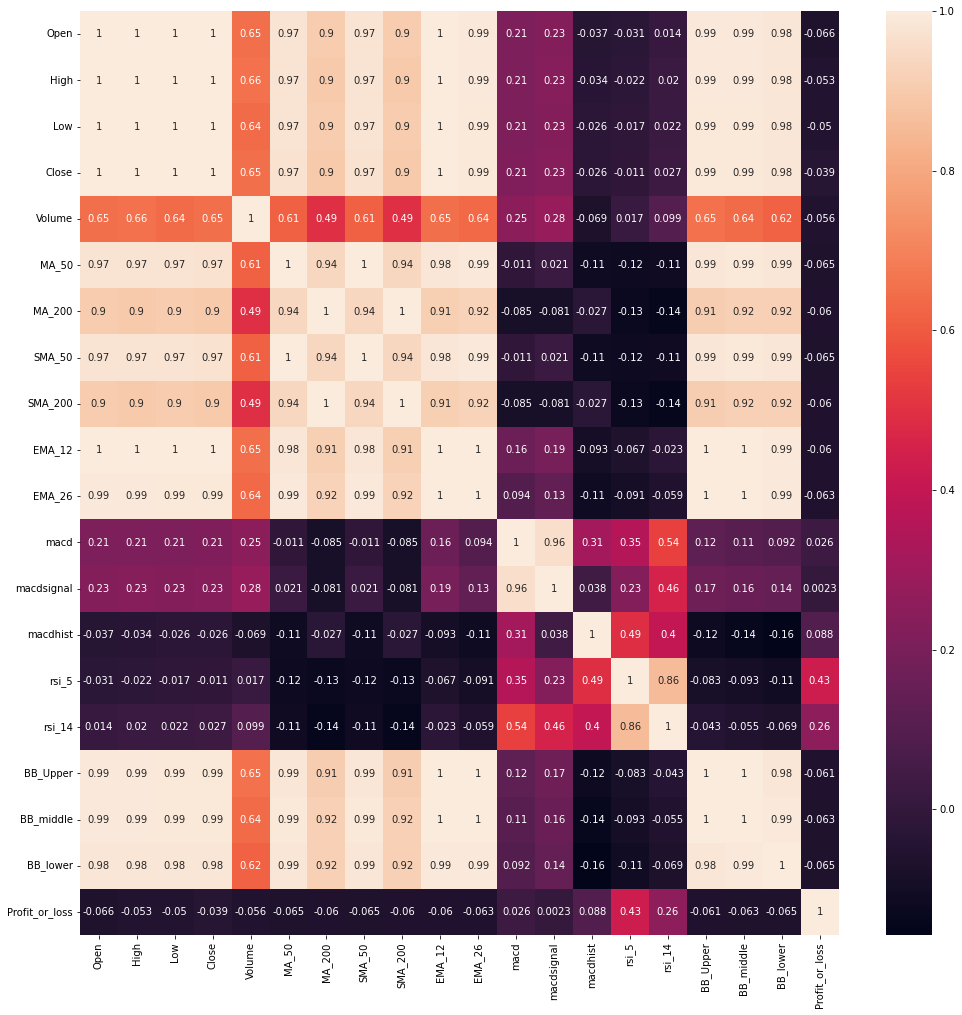

In [25]:
BTC_df.corr()
plt.figure(figsize = (17,17))
sns.heatmap(BTC_df.corr(),annot=True)

In [26]:
feat = BTC_df.columns[1:19]
X = BTC_df[feat]
y = BTC_df['Profit_or_loss']
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [62]:
len(X)

1884

# Split my training data into different time frame

In [27]:
training_days = pd.date_range(start="2017-01-02",end="2021-12-31")
num_training_days = len(training_days)
num_training_days

1825

In [28]:
X_train = scaled_X[:num_training_days]
y_train = y[:num_training_days]
X_test = scaled_X[num_training_days:]
y_test = y[num_training_days:]

In [29]:
print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('y_test shape == {}.'.format(y_test.shape))

X_train shape == (1825, 18).
y_train shape == (1825,).
X_test shape == (59, 18).
y_test shape == (59,).


## Model Selection and also try out using different model 

In [30]:

# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('Decision_Tree' , DecisionTreeClassifier()))
models.append(('SVM' , svm.SVC(kernel='rbf')))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))


In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score, f1_score

Model :LR
Accuracy Score : 0.8305084745762712
f1 Score: 0.8214285714285714
Recall: 0.8214285714285714
precision: 0.8214285714285714
Confusion Matrix :


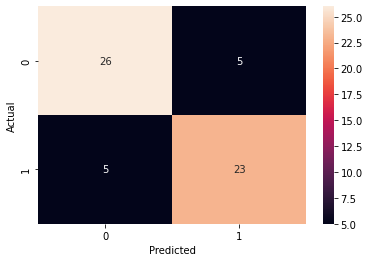

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        31
           1       0.82      0.82      0.82        28

    accuracy                           0.83        59
   macro avg       0.83      0.83      0.83        59
weighted avg       0.83      0.83      0.83        59

Model :KNN
Accuracy Score : 0.6949152542372882
f1 Score: 0.689655172413793
Recall: 0.7142857142857143
precision: 0.6666666666666666
Confusion Matrix :


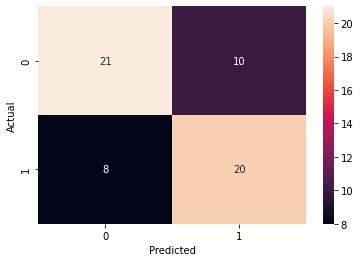

              precision    recall  f1-score   support

           0       0.72      0.68      0.70        31
           1       0.67      0.71      0.69        28

    accuracy                           0.69        59
   macro avg       0.70      0.70      0.69        59
weighted avg       0.70      0.69      0.70        59

Model :Decision_Tree
Accuracy Score : 0.6271186440677966
f1 Score: 0.6333333333333334
Recall: 0.6785714285714286
precision: 0.59375
Confusion Matrix :


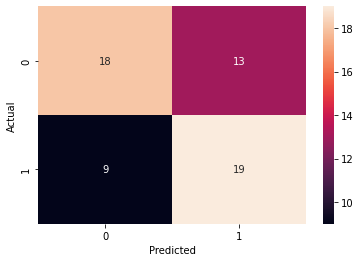

              precision    recall  f1-score   support

           0       0.67      0.58      0.62        31
           1       0.59      0.68      0.63        28

    accuracy                           0.63        59
   macro avg       0.63      0.63      0.63        59
weighted avg       0.63      0.63      0.63        59

Model :SVM
Accuracy Score : 0.6949152542372882
f1 Score: 0.6250000000000001
Recall: 0.5357142857142857
precision: 0.75
Confusion Matrix :


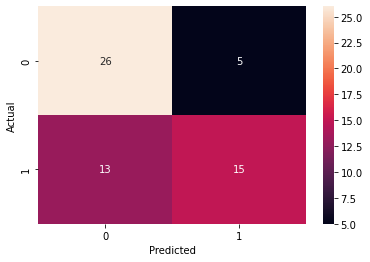

              precision    recall  f1-score   support

           0       0.67      0.84      0.74        31
           1       0.75      0.54      0.63        28

    accuracy                           0.69        59
   macro avg       0.71      0.69      0.68        59
weighted avg       0.71      0.69      0.69        59

Model :RF
Accuracy Score : 0.6949152542372882
f1 Score: 0.6666666666666666
Recall: 0.6428571428571429
precision: 0.6923076923076923
Confusion Matrix :


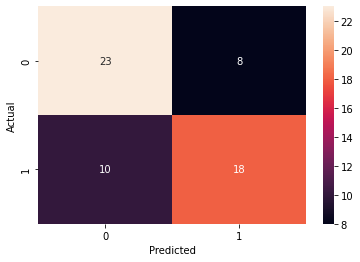

              precision    recall  f1-score   support

           0       0.70      0.74      0.72        31
           1       0.69      0.64      0.67        28

    accuracy                           0.69        59
   macro avg       0.69      0.69      0.69        59
weighted avg       0.69      0.69      0.69        59

[12:06:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Model :XGBoost
Accuracy Score : 0.711864406779661
f1 Score: 0.6792452830188679
Recall: 0.6428571428571429
precision: 0.72
Confusion Matrix :


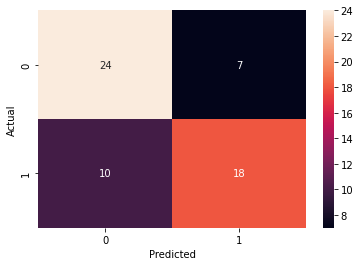

              precision    recall  f1-score   support

           0       0.71      0.77      0.74        31
           1       0.72      0.64      0.68        28

    accuracy                           0.71        59
   macro avg       0.71      0.71      0.71        59
weighted avg       0.71      0.71      0.71        59



In [32]:
results = []
names = []


for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    F1_score=f1_score(y_test, y_pred)
    Recall=recall_score(y_test, y_pred)
    Precision=precision_score(y_test, y_pred)
    results= pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
    print( "Model :" + name)
    print ('Accuracy Score :',accuracy_score(y_test,y_pred))
    print('f1 Score'+": " + str(F1_score))
    print('Recall' + ": " + str(Recall))
    print('precision' + ": " + str(Precision))
    print ('Confusion Matrix :')
    sns.heatmap(results, annot=True)
    plt.show() 
#     print(model.feature_importances_)
    print(classification_report(y_test,y_pred))

In [33]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0], dtype=int64)

In [34]:
np.array(y_test)

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0], dtype=int64)

# Logistic regression

In [35]:
logres = LogisticRegression()
logres.fit(X_train, y_train)
logres_y_pred = logres.predict(X_test)
logres.score(X_test,y_test)

0.8305084745762712

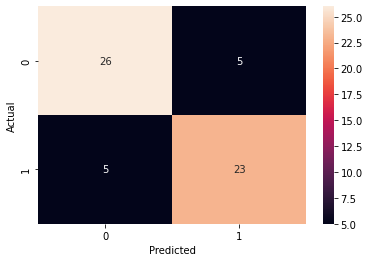

In [36]:
logres_confusion_matrix= pd.crosstab(y_test, logres_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
sns.heatmap(logres_confusion_matrix, annot=True)
plt.show()

In [37]:
logres_final_df = pd.DataFrame(data= np.array(y_test),columns=['Actual'])
logres_final_df['Prediction'] = np.array(logres_y_pred)


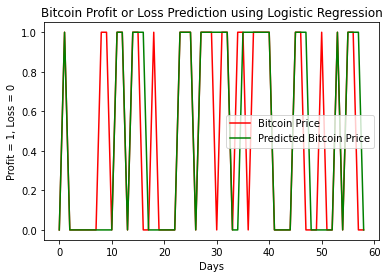

In [38]:
plt.plot(np.array(y_test), color = 'red', label = 'Bitcoin Price')
plt.plot(np.array(logres_y_pred), color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Profit or Loss Prediction using Logistic Regression')
plt.xlabel('Days')
plt.ylabel('Profit = 1, Loss = 0')
plt.legend()
plt.show()

# Grid search to find best parameter. cannot use this before of cross validation 

In [39]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [10,50,100],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [5,10,50]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(),
        'params': {
            'C': [10,50,100]
        }
    },
    'decision_tree' : {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [10,50,100]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'n_neighbors': [10,50,100]
        }
    }
 
}

In [40]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False) # need to remove this line, cann do cross validation for time series 
    clf.fit(X_train,y_train)
    scores.append({
         'model': model_name,
         'best_score': clf.best_score_,
         'best_params': clf.best_params_
     })
    
model_score_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
model_score_df

C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_neighbors" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:06:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,best_score,best_params
0,svm,0.888767,"{'C': 100, 'kernel': 'linear'}"
1,random_forest,0.579726,{'n_estimators': 50}
2,logistic_regression,0.860822,{'C': 100}
3,decision_tree,0.584110,{'criterion': 'entropy'}
4,KNN,0.642740,{'n_neighbors': 100}
5,XGBoost,0.615342,{'n_neighbors': 10}


# Stacking 

In [41]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1884 non-null   datetime64[ns]
 1   Open            1884 non-null   float64       
 2   High            1884 non-null   float64       
 3   Low             1884 non-null   float64       
 4   Close           1884 non-null   float64       
 5   Volume          1884 non-null   int64         
 6   MA_50           1884 non-null   float64       
 7   MA_200          1884 non-null   float64       
 8   SMA_50          1884 non-null   float64       
 9   SMA_200         1884 non-null   float64       
 10  EMA_12          1884 non-null   float64       
 11  EMA_26          1884 non-null   float64       
 12  macd            1884 non-null   float64       
 13  macdsignal      1884 non-null   float64       
 14  macdhist        1884 non-null   float64       
 15  rsi_

In [42]:
# feat = BTC_df.columns[1:19]
# X = BTC_df[feat]
# y = BTC_df['Profit_or_loss']
# scaler = StandardScaler()
# scaled_X = scaler.fit_transform(X)

In [43]:
# X_columns = BTC_df[['Close', 'Volume']]
# scaled_X_columns = scaler.fit_transform(X_columns)
X_1 = np.array(scaled_X)
y_1 = np.array(y)

In [44]:
model1 = svm.SVC(gamma='auto', C = 100, kernel= 'linear')
model2 = KNeighborsClassifier(n_neighbors = 100)
model3 = XGBClassifier( n_estimators = 10)
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
stackingmodel = StackingClassifier(
    classifiers = [model1, model2, model3],
    meta_classifier = lr)

In [45]:
from sklearn.model_selection import RepeatedStratifiedKFold

def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = svm.SVC()
	models['bayes'] = GaussianNB()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X_1, y_1):
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X_1, y_1, scoring='accuracy', cv= 5, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>lr 0.527 (0.035)
>knn 0.484 (0.043)
>cart 0.575 (0.065)
>svm 0.515 (0.036)
>bayes 0.536 (0.033)


In [46]:

label = ['SVC', 'KNN', 'XGBoost', 'Stacking Classifier']
model_list = [model1, model2, model3, stackingmodel]
    
# fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0, 1], repeat = 2)

model_cv_mean = []
model_cv_std = []
for model, label, grd in zip(model_list, label, grid):
        
    
    scores = cross_val_score(model,X_1, y_1, cv = 5, scoring = 'accuracy') #- time series should not do crossval
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
    model_cv_mean.append(scores.mean())
    model_cv_std.append(scores.std())
        
#     model.fit(X_1, y_1)
#     ax = plt.subplot(gs[grd[0], grd[1]])
#     fig = plot_decision_regions(X = X_1, y = y_1, clf = model)
#     plt.title(label)

# plt.show()

# model_score_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
# model_score_df

Accuracy: 0.89 (+/- 0.03) [SVC]
Accuracy: 0.62 (+/- 0.05) [KNN]
[12:06:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:06:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:06:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.63 (+/- 0.06) [XGBoost]


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\.conda\envs\Deep_learning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.82 (+/- 0.04) [Stacking Classifier]


# Plot prediction graph, Try using closing price as Y and use regression model to train the data 
# plot the volumn chart out to see whether there is increasing trend of trading bitcoin
## Base on the volumn check out the news in the market to see what is pushing the price up. 

